# Exploring MesoGEOS Wildfire Dataset

This notebook explores the mesogeos_cube.zarr dataset to understand its structure, dimensions, and variables.

In [1]:
# Import required libraries
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 1. Load the Zarr Dataset

Zarr is a format for storing chunked, compressed N-dimensional arrays. We'll use xarray to load and explore the data.

In [23]:
# Path to the dataset
data_path = '../data/raw/dataset_64_64_all_10days_final/2022/Albania/corrected_sample_9709.nc'

# Load the dataset using xarray
# Auto-detect file format based on extension
if data_path.endswith('.zarr') or 'zarr' in data_path:
    ds = xr.open_zarr(data_path)
    print("Loaded as Zarr dataset")
elif data_path.endswith('.nc') or data_path.endswith('.nc4'):
    ds = xr.open_dataset(data_path)
    print("Loaded as NetCDF dataset")
else:
    # Try NetCDF first (most common), then Zarr
    try:
        ds = xr.open_dataset(data_path, engine="netcdf4")
        print("Loaded as NetCDF dataset")
    except:
        ds = xr.open_zarr(data_path)
        print("Loaded as Zarr dataset")

print(f"Dataset loaded successfully!")
print(f"Dataset type: {type(ds)}")

Loaded as NetCDF dataset
Dataset loaded successfully!
Dataset type: <class 'xarray.core.dataset.Dataset'>


## 2. Dataset Overview

In [24]:
# Display the complete dataset structure
print("=" * 80)
print("DATASET STRUCTURE")
print("=" * 80)
display(ds)

DATASET STRUCTURE


<xarray.Dataset> Size: 3MB
Dimensions:               (y: 64, x: 64, time: 10)
Coordinates:
  * time                  (time) datetime64[ns] 80B 2022-03-18 ... 2022-03-27
  * x                     (x) float64 512B 19.53 19.54 19.55 ... 20.15 20.16
  * y                     (y) float64 512B 42.31 42.3 42.29 ... 41.7 41.69 41.68
Data variables: (12/34)
    aspect                (y, x) float32 16kB ...
    burned_areas          (time, y, x) float32 164kB ...
    curvature             (y, x) float32 16kB ...
    d2m                   (time, y, x) float32 164kB ...
    dem                   (y, x) float32 16kB ...
    ignition_points       (time, y, x) float32 164kB ...
    ...                    ...
    lc_wetland            (y, x) float32 16kB ...
    population            (y, x) float32 16kB ...
    wind_direction_sin    (time, y, x) float32 164kB ...
    wind_direction_cos    (time, y, x) float32 164kB ...
    u                     (time, y, x) float32 164kB ...
    v                     (time, y, x) float32 164kB ...
Attributes:
    country:         Albania
    year:            2022
    date:            2022-03-22
    burned_area_ha:  2124.0

In [18]:
# Get dimensions
print("\nDimensions:")
print("-" * 40)
for dim, size in ds.dims.items():
    print(f"{dim}: {size}")


Dimensions:
----------------------------------------
y: 64
x: 64
time: 10


In [5]:
# Get coordinates
print("\nCoordinates:")
print("-" * 40)
for coord in ds.coords:
    print(f"{coord}: {ds.coords[coord].shape} - {ds.coords[coord].dtype}")


Coordinates:
----------------------------------------
time: (10,) - datetime64[ns]
x: (64,) - float64
y: (64,) - float64


In [6]:
# List all data variables
print("\nData Variables:")
print("-" * 40)
for var in ds.data_vars:
    shape = ds[var].shape
    dtype = ds[var].dtype
    dims = ds[var].dims
    print(f"{var}:")
    print(f"  Shape: {shape}")
    print(f"  Dimensions: {dims}")
    print(f"  Data type: {dtype}")
    print()


Data Variables:
----------------------------------------
aspect:
  Shape: (64, 64)
  Dimensions: ('y', 'x')
  Data type: float32

burned_areas:
  Shape: (10, 64, 64)
  Dimensions: ('time', 'y', 'x')
  Data type: float32

curvature:
  Shape: (64, 64)
  Dimensions: ('y', 'x')
  Data type: float32

d2m:
  Shape: (10, 64, 64)
  Dimensions: ('time', 'y', 'x')
  Data type: float32

dem:
  Shape: (64, 64)
  Dimensions: ('y', 'x')
  Data type: float32

ignition_points:
  Shape: (10, 64, 64)
  Dimensions: ('time', 'y', 'x')
  Data type: float32

lai:
  Shape: (10, 64, 64)
  Dimensions: ('time', 'y', 'x')
  Data type: float32

lst_day:
  Shape: (10, 64, 64)
  Dimensions: ('time', 'y', 'x')
  Data type: float32

lst_night:
  Shape: (10, 64, 64)
  Dimensions: ('time', 'y', 'x')
  Data type: float32

ndvi:
  Shape: (10, 64, 64)
  Dimensions: ('time', 'y', 'x')
  Data type: float32

rh:
  Shape: (10, 64, 64)
  Dimensions: ('time', 'y', 'x')
  Data type: float32

roads_distance:
  Shape: (64, 64)
  

## 3. Explore Individual Variables

In [7]:
# Examine attributes of each variable
print("Variable Attributes:")
print("=" * 80)

for var in ds.data_vars:
    print(f"\n{var}:")
    print("-" * 40)
    if ds[var].attrs:
        for attr_name, attr_value in ds[var].attrs.items():
            print(f"  {attr_name}: {attr_value}")
    else:
        print("  No attributes found")

Variable Attributes:

aspect:
----------------------------------------
  grid_mapping: spatial_ref

burned_areas:
----------------------------------------
  grid_mapping: spatial_ref

curvature:
----------------------------------------
  grid_mapping: spatial_ref

d2m:
----------------------------------------
  grid_mapping: spatial_ref

dem:
----------------------------------------
  grid_mapping: spatial_ref

ignition_points:
----------------------------------------
  grid_mapping: spatial_ref

lai:
----------------------------------------
  grid_mapping: spatial_ref

lst_day:
----------------------------------------
  grid_mapping: spatial_ref

lst_night:
----------------------------------------
  grid_mapping: spatial_ref

ndvi:
----------------------------------------
  grid_mapping: spatial_ref

rh:
----------------------------------------
  grid_mapping: spatial_ref

roads_distance:
----------------------------------------
  grid_mapping: spatial_ref

slope:
--------------------

In [8]:
# Get statistics for each variable
print("\nVariable Statistics:")
print("=" * 80)

for var in ds.data_vars:
    print(f"\n{var}:")
    print("-" * 40)
    try:
        data = ds[var]
        print(f"  Min: {float(data.min().values):.4f}")
        print(f"  Max: {float(data.max().values):.4f}")
        print(f"  Mean: {float(data.mean().values):.4f}")
        print(f"  Std: {float(data.std().values):.4f}")
        
        # Check for NaN values
        nan_count = np.isnan(data.values).sum()
        total_count = data.size
        print(f"  NaN values: {nan_count} / {total_count} ({100*nan_count/total_count:.2f}%)")
    except Exception as e:
        print(f"  Error computing statistics: {e}")


Variable Statistics:

aspect:
----------------------------------------
  Min: 0.0292
  Max: 359.9438
  Mean: 192.1586
  Std: 93.8938
  NaN values: 0 / 4096 (0.00%)

burned_areas:
----------------------------------------
  Min: 0.0000
  Max: 1.0000
  Mean: 0.0014
  Std: 0.0379
  NaN values: 0 / 40960 (0.00%)

curvature:
----------------------------------------
  Min: -99105.9922
  Max: 104768.4453
  Mean: -186.0039
  Std: 26110.4238
  NaN values: 0 / 4096 (0.00%)

d2m:
----------------------------------------
  Min: 0.0000
  Max: 284.2079
  Mean: 246.4549
  Std: 80.1003
  NaN values: 0 / 40960 (0.00%)

dem:
----------------------------------------
  Min: -1.3987
  Max: 2404.7581
  Mean: 581.9941
  Std: 537.0157
  NaN values: 0 / 4096 (0.00%)

ignition_points:
----------------------------------------
  Min: 0.0000
  Max: 508.0000
  Mean: 0.0283
  Std: 3.0169
  NaN values: 0 / 40960 (0.00%)

lai:
----------------------------------------
  Min: 0.0000
  Max: 7.0000
  Mean: 0.5502
  Std: 0

## 4. Temporal Analysis

Explore the temporal dimension if it exists.

In [9]:
# Check for time dimension
time_dims = ['time', 'Time', 'date', 'timestamp']
time_coord = None

for dim in time_dims:
    if dim in ds.dims:
        time_coord = dim
        break

if time_coord:
    print(f"Time coordinate found: {time_coord}")
    print(f"Number of timesteps: {len(ds[time_coord])}")
    print(f"\nFirst timestep: {ds[time_coord].values[0]}")
    print(f"Last timestep: {ds[time_coord].values[-1]}")
    
    # Show sample of time values
    print(f"\nSample time values (first 10):")
    print(ds[time_coord].values[:10])
else:
    print("No standard time dimension found in dataset")
    print(f"Available dimensions: {list(ds.dims.keys())}")

Time coordinate found: time
Number of timesteps: 10

First timestep: 2022-03-17T00:00:00.000000000
Last timestep: 2022-03-26T00:00:00.000000000

Sample time values (first 10):
['2022-03-17T00:00:00.000000000' '2022-03-18T00:00:00.000000000'
 '2022-03-19T00:00:00.000000000' '2022-03-20T00:00:00.000000000'
 '2022-03-21T00:00:00.000000000' '2022-03-22T00:00:00.000000000'
 '2022-03-23T00:00:00.000000000' '2022-03-24T00:00:00.000000000'
 '2022-03-25T00:00:00.000000000' '2022-03-26T00:00:00.000000000']


## 5. Spatial Analysis

Explore spatial dimensions (latitude, longitude, x, y).

In [10]:
# Check for spatial coordinates
spatial_coords = ['lat', 'latitude', 'lon', 'longitude', 'x', 'y']

print("Spatial Coordinates:")
print("=" * 80)

for coord in spatial_coords:
    if coord in ds.coords or coord in ds.dims:
        print(f"\n{coord}:")
        if coord in ds.coords:
            values = ds.coords[coord].values
        else:
            values = ds[coord].values if coord in ds else None
        
        if values is not None:
            print(f"  Range: [{values.min():.4f}, {values.max():.4f}]")
            print(f"  Shape: {values.shape}")
            print(f"  Resolution: {np.diff(values).mean():.6f}" if len(values) > 1 else "  Single value")

Spatial Coordinates:

x:
  Range: [19.3771, 20.0114]
  Shape: (64,)
  Resolution: 0.010069

y:
  Range: [41.7988, 42.4332]
  Shape: (64,)
  Resolution: -0.010069


## 6. Visualization

Create visualizations of the data.

Found 14 static variables and 19 dynamic variables

Static variables: ['aspect', 'curvature', 'dem', 'roads_distance', 'slope', 'lc_agriculture', 'lc_forest', 'lc_grassland', 'lc_settlement', 'lc_shrubland', 'lc_sparse_vegetation', 'lc_water_bodies', 'lc_wetland', 'population']

Dynamic variables: ['burned_areas', 'd2m', 'ignition_points', 'lai', 'lst_day', 'lst_night', 'ndvi', 'rh', 'smi', 'sp', 'ssrd', 't2m', 'tp', 'wind_direction', 'wind_speed', 'wind_direction_sin', 'wind_direction_cos', 'u', 'v']

PLOTTING STATIC VARIABLES (TERRAIN & LAND COVER)


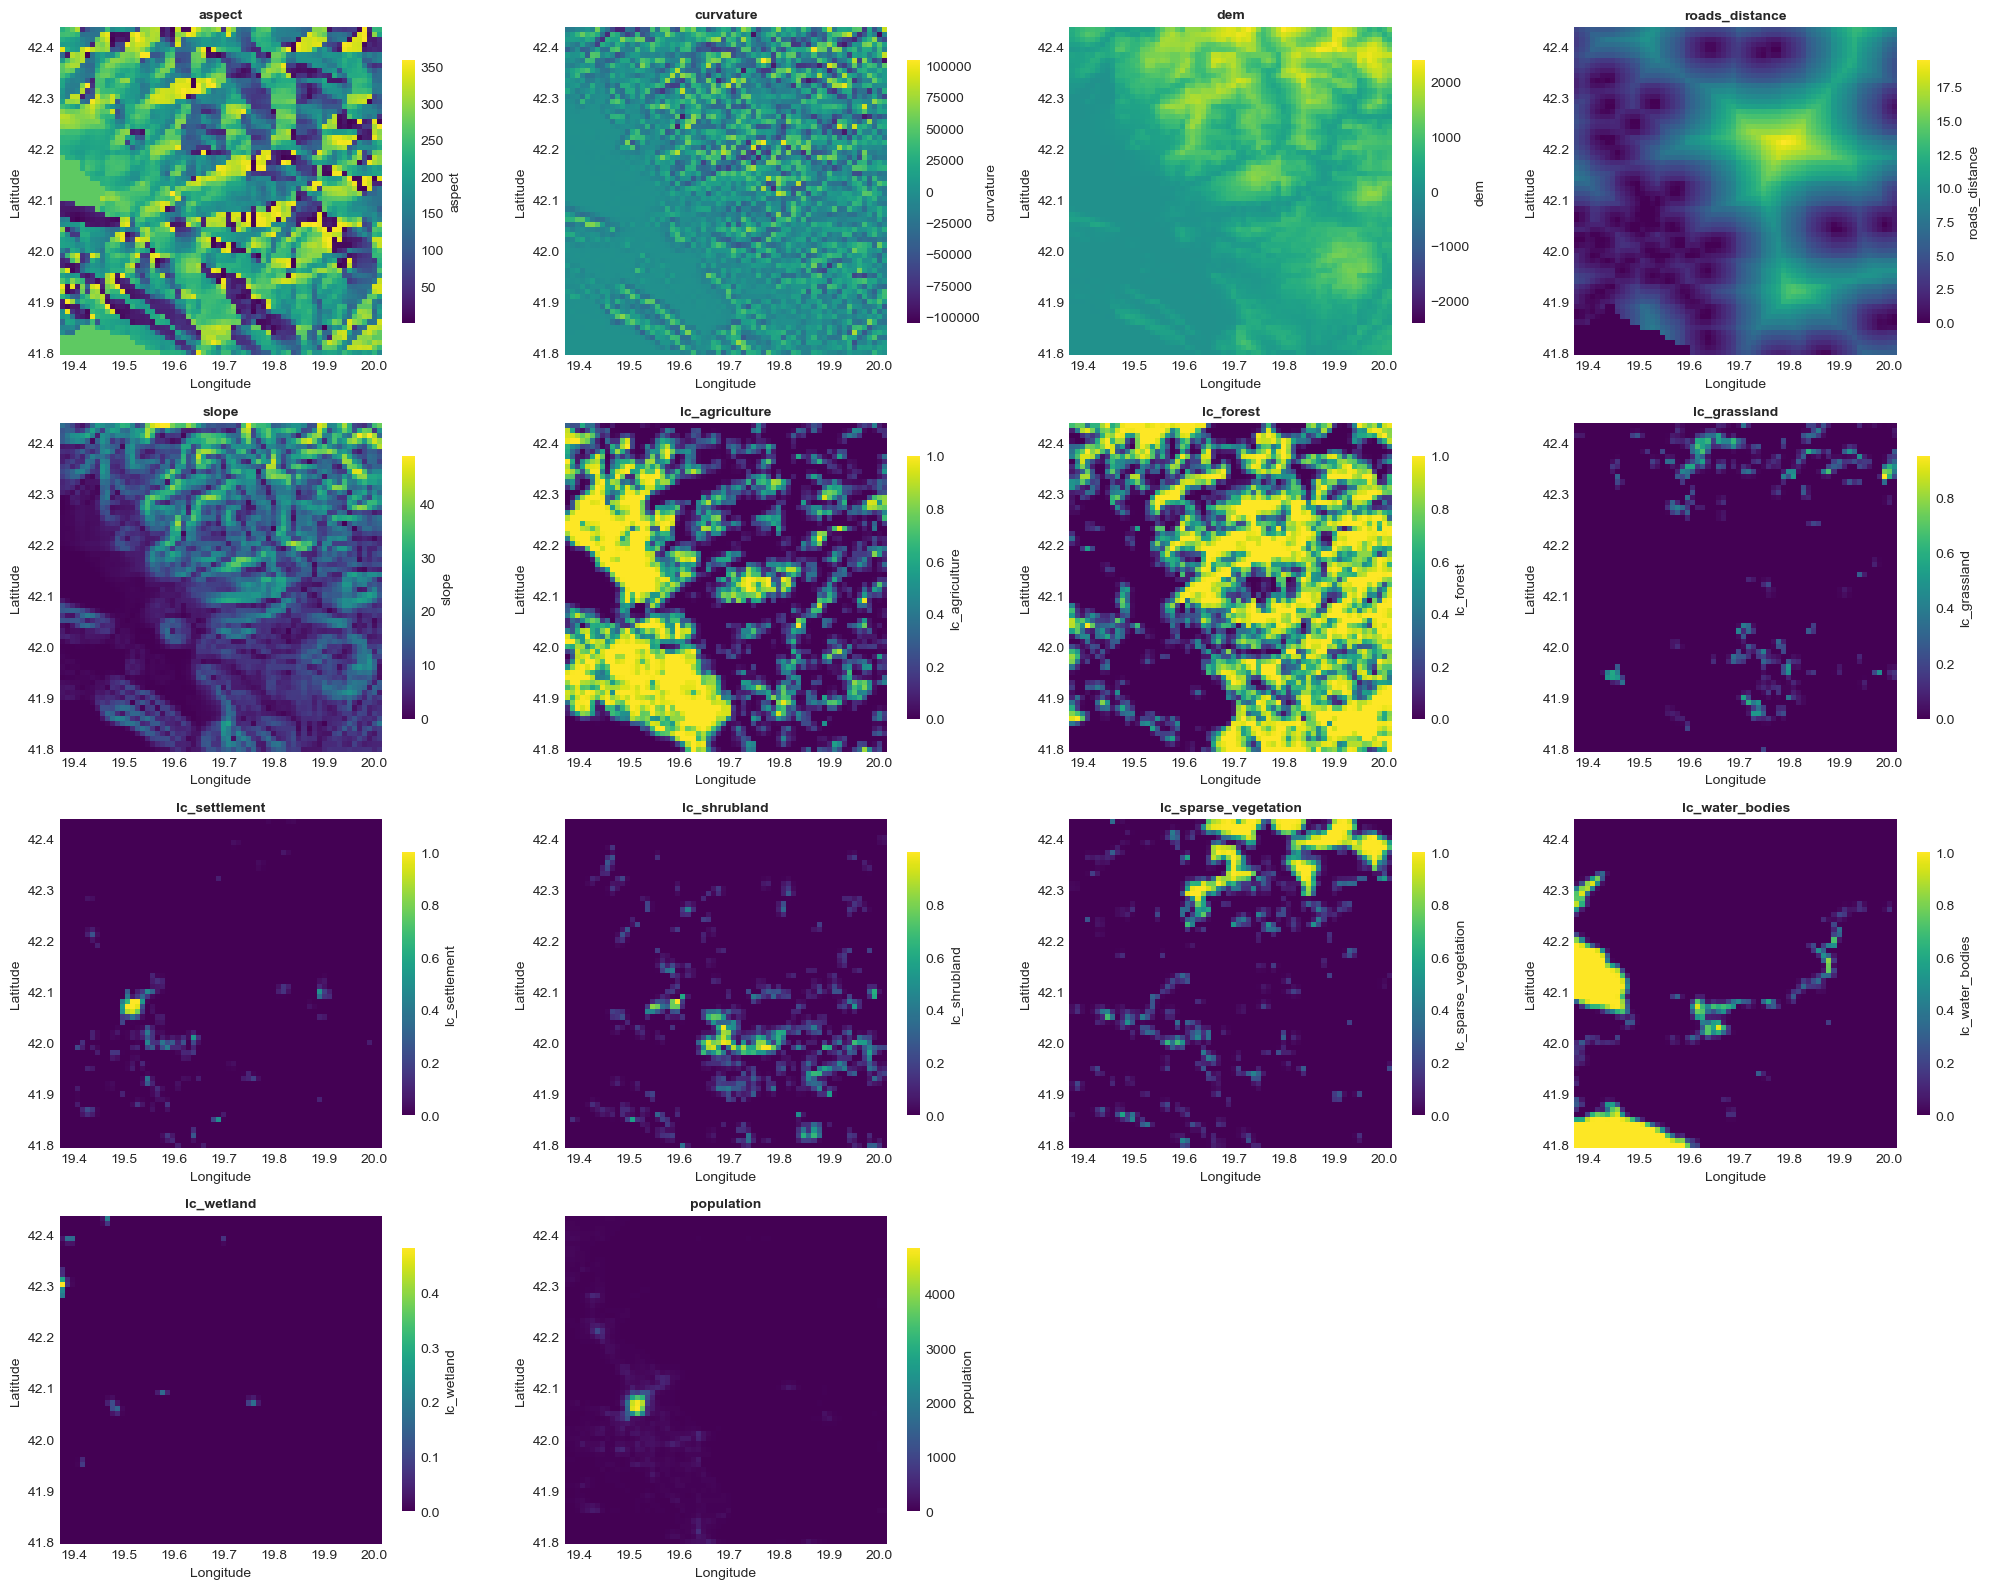


PLOTTING DYNAMIC VARIABLES (t=0, First Timestep)


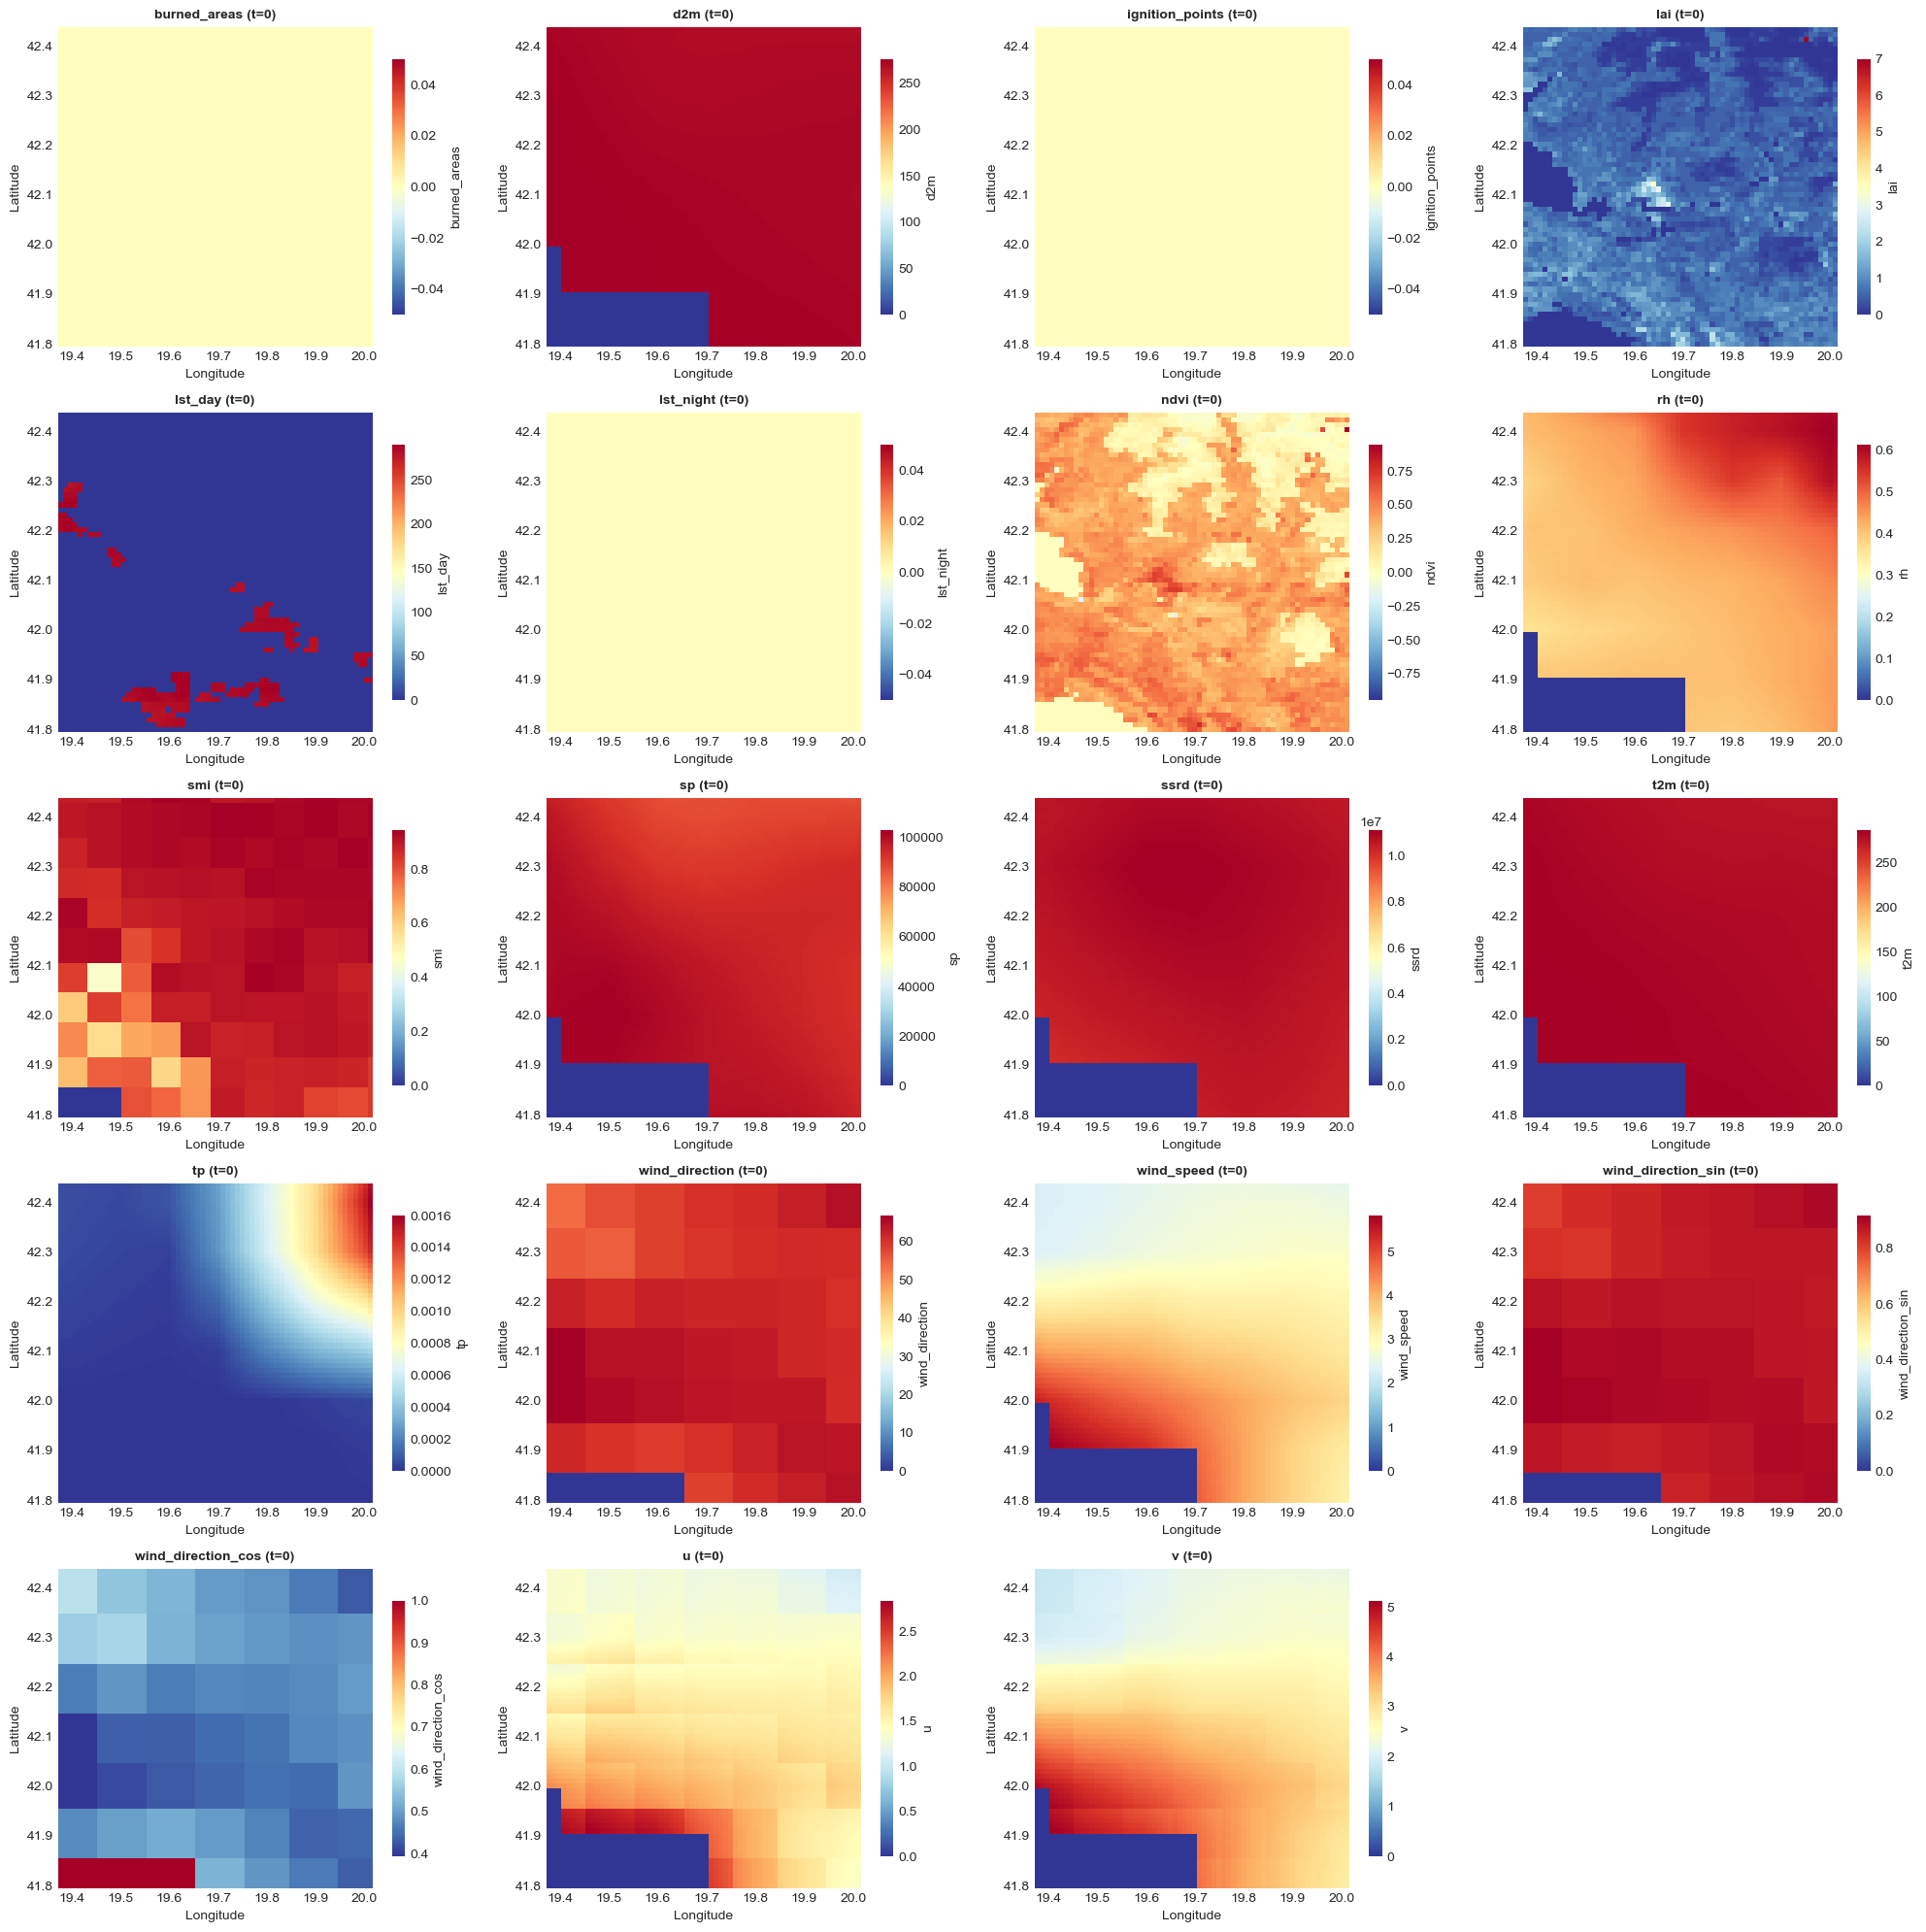


BURNED AREAS EVOLUTION OVER TIME


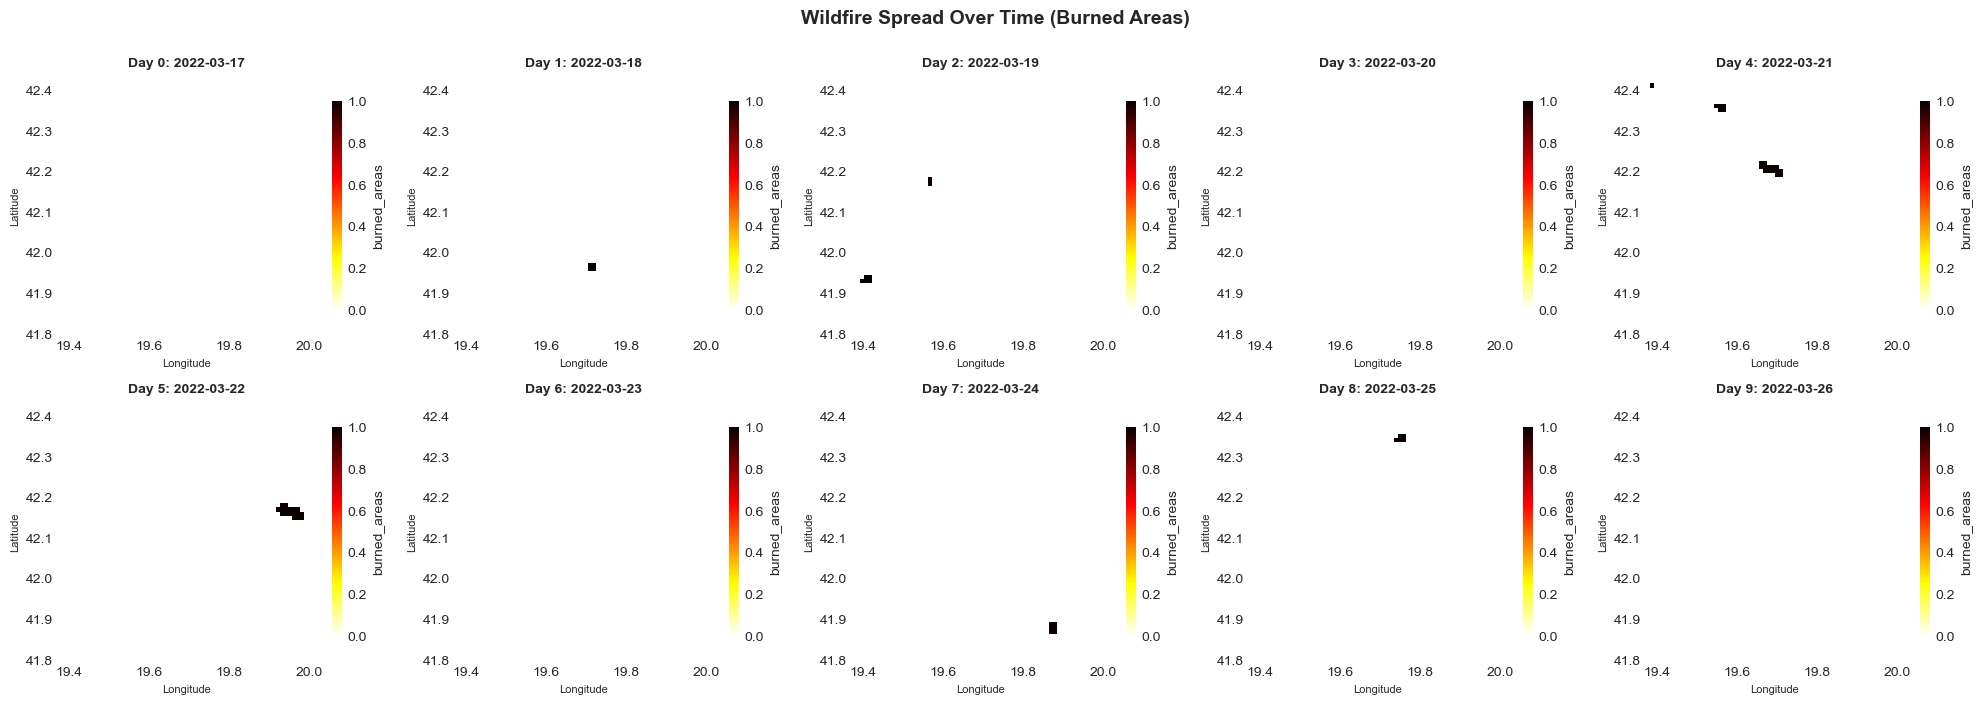


KEY ENVIRONMENTAL VARIABLES OVER TIME


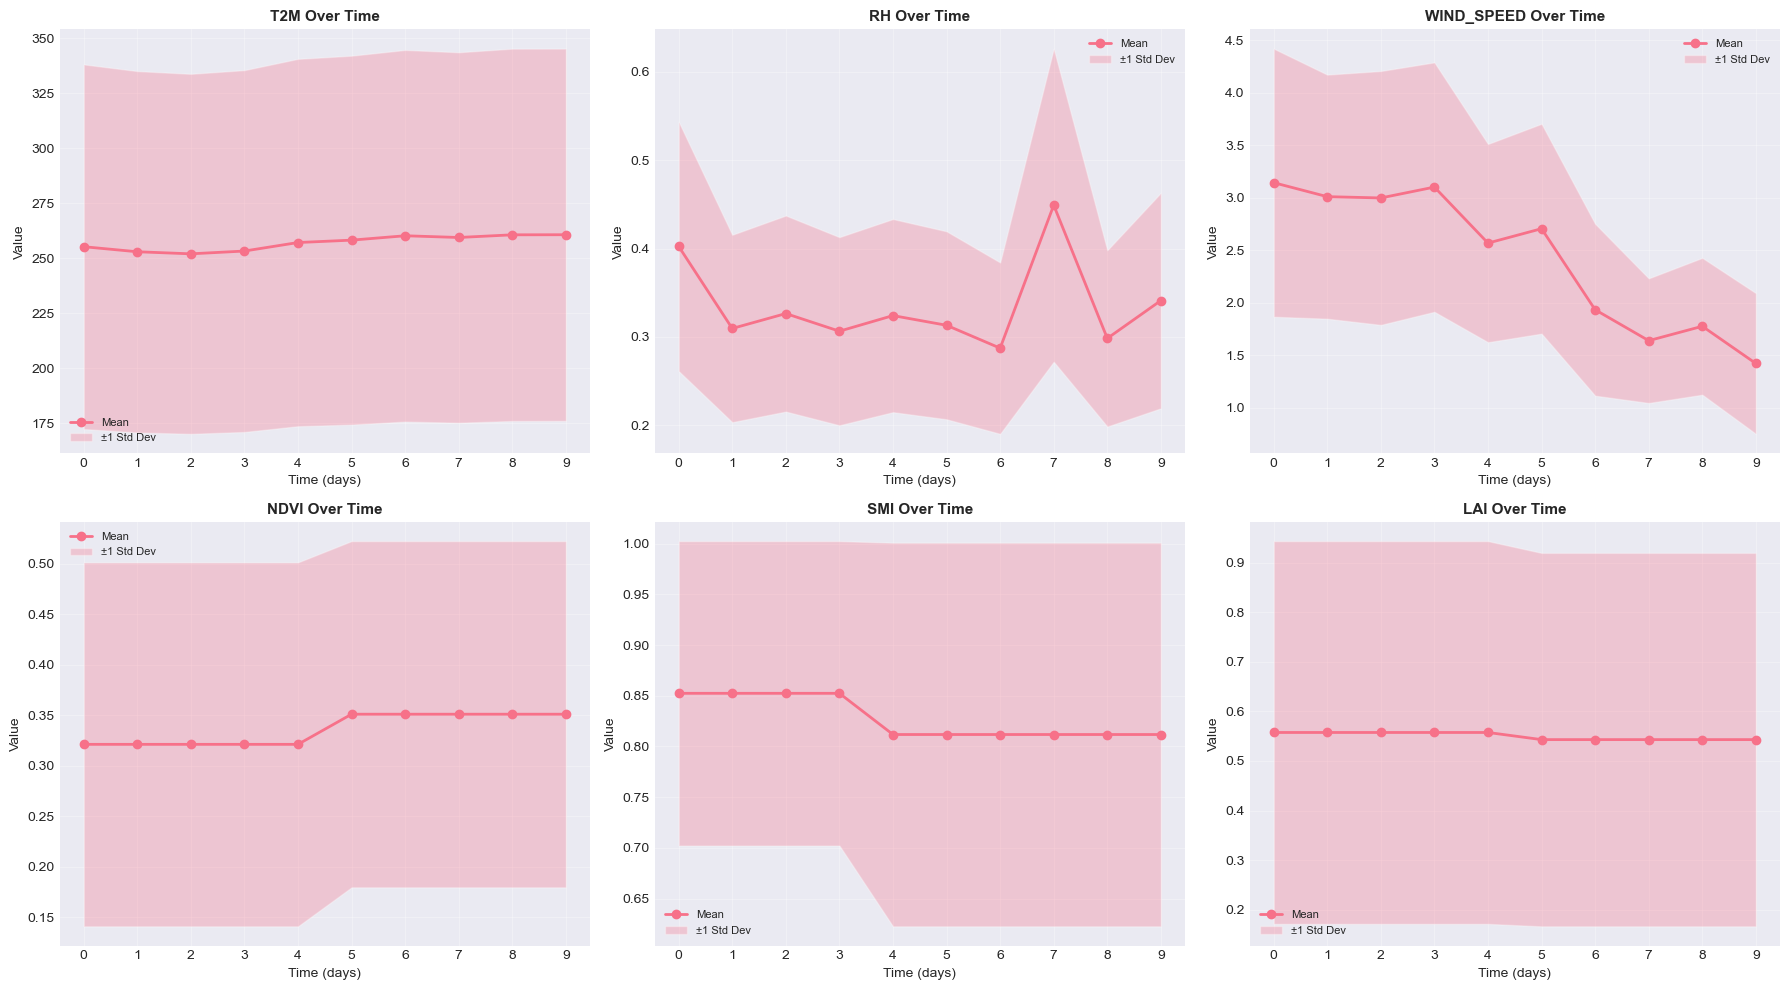


CORRELATION ANALYSIS (First Timestep)


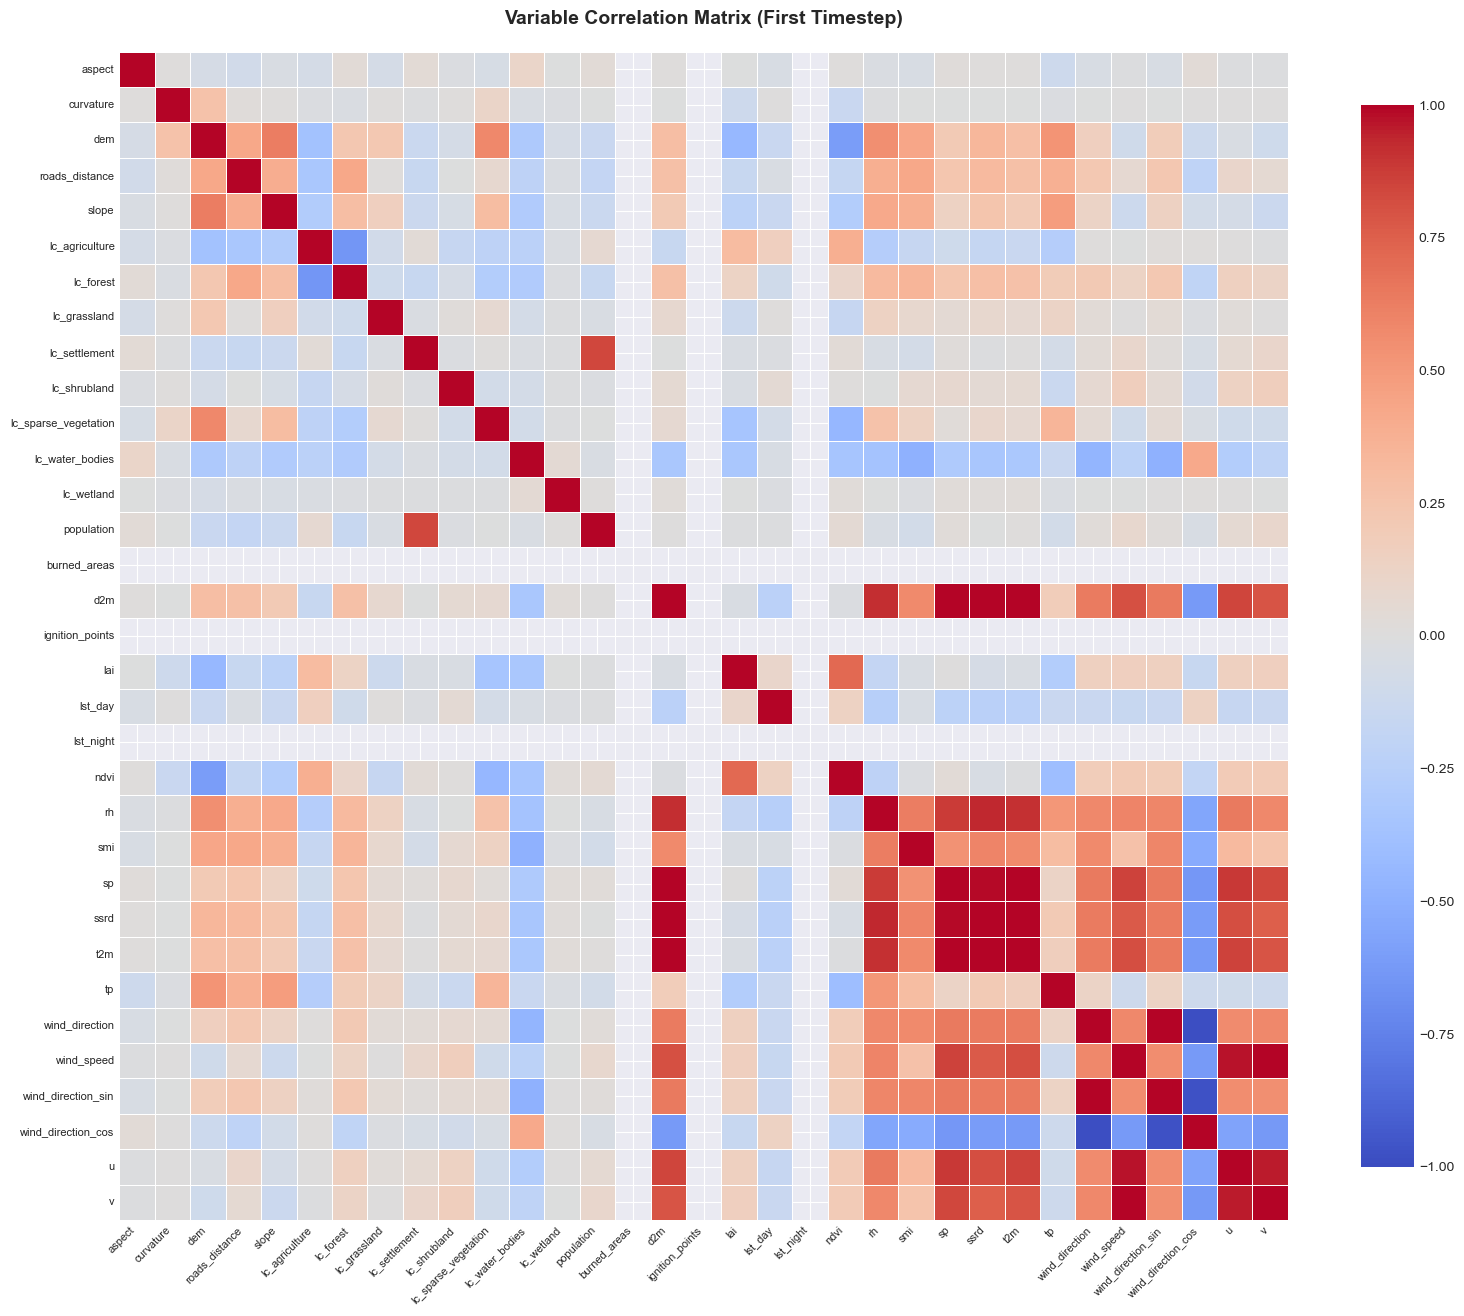


Visualization complete!


In [15]:
# Visualize key variables
import warnings
warnings.filterwarnings('ignore')

# Get list of all data variables (excluding spatial_ref which is metadata)
vars_to_plot = [var for var in ds.data_vars if var != 'spatial_ref']

# Separate into static (terrain/land cover) and dynamic (temporal) variables
static_vars = [var for var in vars_to_plot if len(ds[var].shape) == 2]
dynamic_vars = [var for var in vars_to_plot if len(ds[var].shape) == 3]

print(f"Found {len(static_vars)} static variables and {len(dynamic_vars)} dynamic variables")
print(f"\nStatic variables: {static_vars}")
print(f"\nDynamic variables: {dynamic_vars}")

# Plot 1: Static Variables (Terrain & Land Cover)
print("\n" + "="*80)
print("PLOTTING STATIC VARIABLES (TERRAIN & LAND COVER)")
print("="*80)

n_static = len(static_vars)
n_cols = 4
n_rows = (n_static + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
axes = axes.flatten() if n_static > 1 else [axes]

for idx, var in enumerate(static_vars):
    ax = axes[idx]
    im = ds[var].plot(ax=ax, cmap='viridis', add_colorbar=True, cbar_kwargs={'shrink': 0.8})
    ax.set_title(f'{var}', fontsize=10, fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

# Hide unused subplots
for idx in range(n_static, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Plot 2: Dynamic Variables - First Timestep
print("\n" + "="*80)
print("PLOTTING DYNAMIC VARIABLES (t=0, First Timestep)")
print("="*80)

n_dynamic = len(dynamic_vars)
n_cols = 4
n_rows = (n_dynamic + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
axes = axes.flatten() if n_dynamic > 1 else [axes]

for idx, var in enumerate(dynamic_vars):
    ax = axes[idx]
    # Plot first timestep (t=0)
    data_slice = ds[var].isel(time=0)
    im = data_slice.plot(ax=ax, cmap='RdYlBu_r', add_colorbar=True, cbar_kwargs={'shrink': 0.8})
    ax.set_title(f'{var} (t=0)', fontsize=10, fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

# Hide unused subplots
for idx in range(n_dynamic, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Plot 3: Burned Areas Evolution Over Time
print("\n" + "="*80)
print("BURNED AREAS EVOLUTION OVER TIME")
print("="*80)

n_timesteps = len(ds.time)
n_cols = 5
n_rows = (n_timesteps + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*3.5))
axes = axes.flatten()

for t in range(n_timesteps):
    ax = axes[t]
    data_slice = ds['burned_areas'].isel(time=t)
    im = data_slice.plot(ax=ax, cmap='hot_r', add_colorbar=True, 
                          cbar_kwargs={'shrink': 0.8}, vmin=0, vmax=1)
    time_str = pd.to_datetime(ds.time.values[t]).strftime('%Y-%m-%d')
    ax.set_title(f'Day {t}: {time_str}', fontsize=10, fontweight='bold')
    ax.set_xlabel('Longitude', fontsize=8)
    ax.set_ylabel('Latitude', fontsize=8)

# Hide unused subplots
for idx in range(n_timesteps, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Wildfire Spread Over Time (Burned Areas)', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Plot 4: Key Environmental Variables Evolution
print("\n" + "="*80)
print("KEY ENVIRONMENTAL VARIABLES OVER TIME")
print("="*80)

# Select key variables for temporal analysis
key_vars = ['t2m', 'rh', 'wind_speed', 'ndvi', 'smi', 'lai']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, var in enumerate(key_vars):
    ax = axes[idx]
    
    # Calculate mean value over spatial dimensions for each timestep
    temporal_mean = ds[var].mean(dim=['x', 'y']).values
    temporal_std = ds[var].std(dim=['x', 'y']).values
    
    time_vals = range(len(ds.time))
    ax.plot(time_vals, temporal_mean, marker='o', linewidth=2, markersize=6, label='Mean')
    ax.fill_between(time_vals, 
                     temporal_mean - temporal_std, 
                     temporal_mean + temporal_std, 
                     alpha=0.3, label='±1 Std Dev')
    
    ax.set_xlabel('Time (days)', fontsize=10)
    ax.set_ylabel('Value', fontsize=10)
    ax.set_title(f'{var.upper()} Over Time', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=8)
    ax.set_xticks(time_vals)

plt.tight_layout()
plt.show()

# Plot 5: Correlation Heatmap (First timestep)
print("\n" + "="*80)
print("CORRELATION ANALYSIS (First Timestep)")
print("="*80)

# Create a dataframe with all variables at first timestep
correlation_data = {}

for var in static_vars:
    correlation_data[var] = ds[var].values.flatten()

for var in dynamic_vars:
    correlation_data[var] = ds[var].isel(time=0).values.flatten()

df_corr = pd.DataFrame(correlation_data)

# Calculate correlation matrix
correlation_matrix = df_corr.corr()

# Plot correlation heatmap
fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)
ax.set_title('Variable Correlation Matrix (First Timestep)', fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

print("\nVisualization complete!")

## 7. Dataset Summary

Create a comprehensive summary of the dataset for documentation.

In [13]:
# Create a summary dictionary
summary = {
    'dataset_path': data_path,
    'dimensions': dict(ds.dims),
    'coordinates': list(ds.coords),
    'data_variables': list(ds.data_vars),
    'total_size_bytes': sum(ds[var].nbytes for var in ds.data_vars),
}

print("\nDATASET SUMMARY")
print("=" * 80)
print(f"Path: {summary['dataset_path']}")
print(f"\nDimensions: {summary['dimensions']}")
print(f"\nCoordinates: {summary['coordinates']}")
print(f"\nData Variables ({len(summary['data_variables'])}): {summary['data_variables']}")
print(f"\nTotal Size: {summary['total_size_bytes'] / (1024**3):.2f} GB")

# Global attributes
if ds.attrs:
    print("\nGlobal Attributes:")
    print("-" * 40)
    for attr_name, attr_value in ds.attrs.items():
        print(f"{attr_name}: {attr_value}")


DATASET SUMMARY
Path: ../data/raw/dataset_64_64_all_10days_final/2022/Albania/corrected_sample_9694.nc

Dimensions: {'y': 64, 'x': 64, 'time': 10}

Coordinates: ['time', 'x', 'y']

Data Variables (34): ['aspect', 'burned_areas', 'curvature', 'd2m', 'dem', 'ignition_points', 'lai', 'lst_day', 'lst_night', 'ndvi', 'rh', 'roads_distance', 'slope', 'smi', 'sp', 'spatial_ref', 'ssrd', 't2m', 'tp', 'wind_direction', 'wind_speed', 'lc_agriculture', 'lc_forest', 'lc_grassland', 'lc_settlement', 'lc_shrubland', 'lc_sparse_vegetation', 'lc_water_bodies', 'lc_wetland', 'population', 'wind_direction_sin', 'wind_direction_cos', 'u', 'v']

Total Size: 0.00 GB

Global Attributes:
----------------------------------------
country: Albania
year: 2022
date: 2022-03-21
burned_area_ha: 2498.0


/var/folders/m_/d56x3sy92kb47fqrhn6mbff80000gn/T/ipykernel_89941/2700078374.py:4: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dimensions': dict(ds.dims),


## 8. Export Summary to CSV

Export key information for future reference.

In [14]:
# Create a dataframe with variable information
var_info = []

for var in ds.data_vars:
    var_info.append({
        'variable': var,
        'dimensions': str(ds[var].dims),
        'shape': str(ds[var].shape),
        'dtype': str(ds[var].dtype),
        'min': float(ds[var].min().values),
        'max': float(ds[var].max().values),
        'mean': float(ds[var].mean().values),
        'std': float(ds[var].std().values),
    })

df_summary = pd.DataFrame(var_info)
print("\nVariable Summary Table:")
display(df_summary)

# Save to CSV
output_path = '../data/processed/mesogeos_summary.csv'
df_summary.to_csv(output_path, index=False)
print(f"\nSummary saved to: {output_path}")


Variable Summary Table:


,variable,dimensions,shape,dtype,min,max,mean,std
0,aspect,"('y', 'x')","(64, 64)",float32,0.029184,3.599438e+02,1.921586e+02,9.389378e+01
1,burned_areas,"('time', 'y', 'x')","(10, 64, 64)",float32,0.000000,1.000000e+00,1.440430e-03,3.793536e-02
2,curvature,"('y', 'x')","(64, 64)",float32,-99105.992188,1.047684e+05,-1.860039e+02,2.611042e+04
3,d2m,"('time', 'y', 'x')","(10, 64, 64)",float32,0.000000,2.842079e+02,2.464549e+02,8.010027e+01
4,dem,"('y', 'x')","(64, 64)",float32,-1.398680,2.404758e+03,5.819941e+02,5.370157e+02
5,ignition_points,"('time', 'y', 'x')","(10, 64, 64)",float32,0.000000,5.080000e+02,2.827149e-02,3.016868e+00
6,lai,"('time', 'y', 'x')","(10, 64, 64)",float32,0.000000,7.000000e+00,5.502275e-01,3.815212e-01
7,lst_day,"('time', 'y', 'x')","(10, 64, 64)",float32,0.000000,3.037600e+02,2.190455e+02,1.227696e+02
8,lst_night,"('time', 'y', 'x')","(10, 64, 64)",float32,0.000000,2.866800e+02,2.063457e+02,1.207564e+02
9,ndvi,"('time', 'y', 'x')","(10, 64, 64)",float32,-0.180800,9.463000e-01,3.362371e-01,1.765724e-01



Summary saved to: ../data/processed/mesogeos_summary.csv


## 9. Next Steps

Based on the exploration above:
1. Identify relevant features for wildfire prediction (temperature, wind, humidity, vegetation, etc.)
2. Check data quality and completeness
3. Plan preprocessing steps (normalization, handling missing values, etc.)
4. Design the model architecture based on spatial-temporal structure
5. Create train/validation/test splits